## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm",
                     "font.size": 8})
plt.style.use("dark_background")

## Numerical methods

In [2]:
def relax_cartesian(phi, mask, error=1E-6, max_n=10**5):
    clipped_mask = mask[1:-1, 1:-1]
    n = 0
    while n < max_n:
        past_phi = phi.copy()
        phi[1:-1, 1:-1][clipped_mask==0] = (phi[:-2, 1:-1] + phi[2:, 1:-1]
                                          + phi[1:-1, 2:]
                                          + phi[1:-1, :-2])[clipped_mask==0] / 4
        if np.max(np.abs(past_phi - phi)) < error:
            break
        n += 1
        if n >= max_n:
            raise StopIteration("Maximum number of iterations exceeded without" \
                                "reaching desired convergence.")
    return phi, n, np.max(np.abs(past_phi - phi))

def square_mask(inner_points, outer_points):
    diff_points = outer_points - inner_points
    mask = np.zeros((outer_points, outer_points))
    mask[diff_points//2:-diff_points//2, diff_points//2:-diff_points//2] = 1
    return mask

def circular_mask(Y, X, r):
    mask = np.zeros(Y.shape)
    mask[X**2 + Y**2 < r**2] = 1
    return mask

def gradient_2d(phi, step):
    gradx, grady = np.zeros(phi.shape), np.zeros(phi.shape)
    # X
    gradx[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2*step)
    gradx[:, 0] = (phi[:, 1] - phi[:, 0]) / step
    gradx[:, -1] = (phi[:, -1] - phi[:, -2]) / step

    # Y, with a minus sign to accomodate phior Y arrays being traversed
    # in the minus-Y cartesian direction, i.e., downwards.
    grady[1:-1, :] = -(phi[2:, :] - phi[:-2, :]) / (2*step)
    grady[0, :] = -(phi[1, :] - phi[0, :]) / step
    grady[-1, :] = -(phi[-1, :] - phi[-2, :]) / step
    return gradx, grady

def get_field(phi, step):
    Ex, Ey = gradient_2d(phi, step)
    Ex, Ey = -Ex, -Ey
    E = np.sqrt(Ex**2 + Ey**2)
    return Ex, Ey, E

## Plotting

In [3]:
def plot_potential(phi, fig, ax, title, extent):
    ax.set(xlabel="Posición en $x$ [$L$]", ylabel="Posción en $y$ [$L$]", title=title)

    im = ax.imshow(phi/np.max(phi0), cmap=plt.cm.BuPu_r, extent=extent)
    ax.contour(X, Y, phi, colors='white', linewidths=1, linestyles='--')
    fig.colorbar(im, label="Potencial ($\phi$) [$\phi_{max}$]", fraction=0.046, pad=0.04)

def plot_field(Ex, Ey, E, fig, ax, title, quiver_step, equal_lengths=True, arrow_rescale=1):
    # Changing arrow spacing
    quiver_X, quiver_Y = X[::quiver_step, ::quiver_step], Y[::quiver_step, ::quiver_step]
    Ex = Ex[::quiver_step, ::quiver_step]
    Ey = Ey[::quiver_step, ::quiver_step]
    E = E[::quiver_step, ::quiver_step]
    
    # Normalization
    if equal_lengths:
        Ex[E > 0], Ey[E > 0] = Ex[E > 0] / E[E > 0], Ey[E > 0] / E[E > 0]
    else:
        Ex, Ey = arrow_rescale * Ex / np.max(E), arrow_rescale * Ey / np.max(E)

    # Plotting
    ax.set(xlabel="Posición en $x$ [$L$]", ylabel="Posción en $y$ [$L$]", title=title)
    ax.set_aspect('equal')
    quiver = ax.quiver(quiver_X, quiver_Y, Ex, Ey, E/np.max(E), pivot='mid',
                       cmap=plt.cm.BuPu_r)
    fig.colorbar(quiver, label="Magnitud de campo eléctrico ($E$) [$E_{max}$]",
                 fraction=0.046, pad=0.04)

## Example 1: Sheet at constant potential

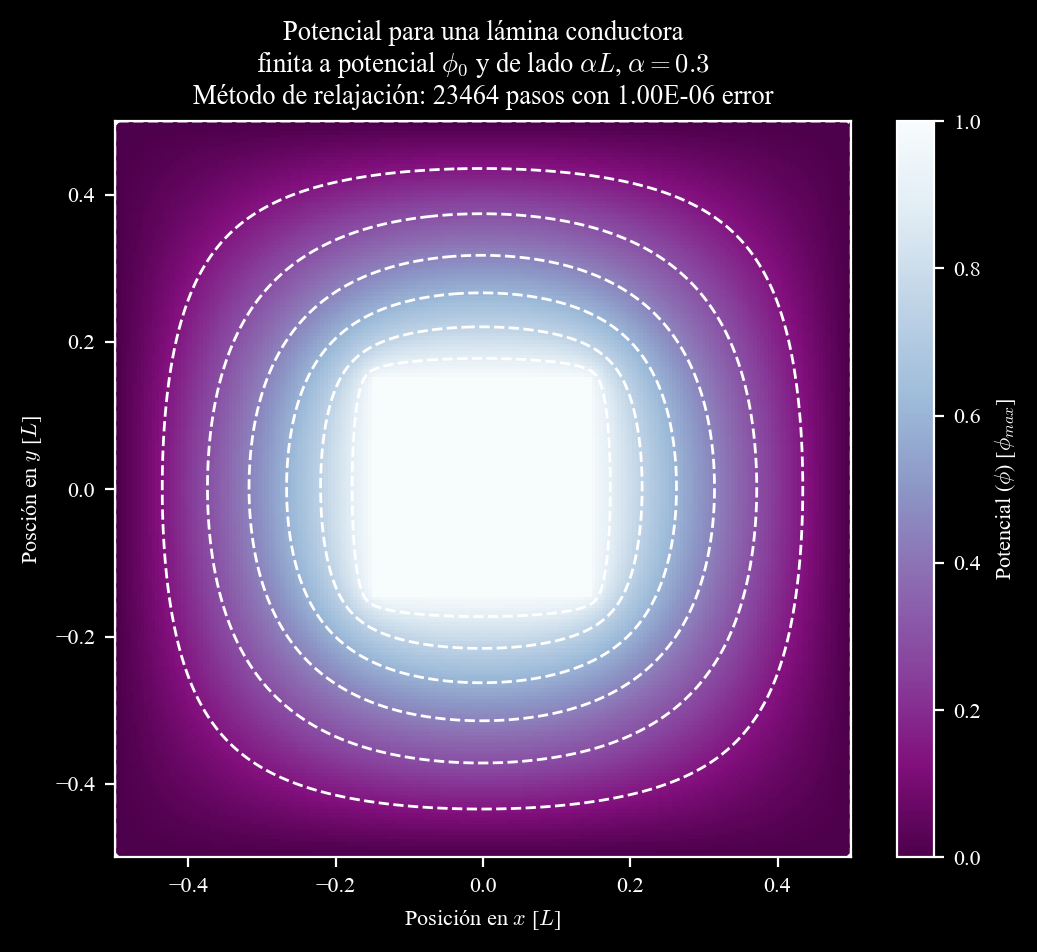

In [4]:
# Geometric parameters
alpha = 0.3
outer_length = 1
inner_length = alpha*outer_length
step = 0.005
outer_points, inner_points = int(outer_length/step)+1, int(inner_length/step)

# Position and mask
# Y, X used to plot the electric field
# Y starts on outer_length/2 and decreases to -outer_length/2 so as to have
# the maximum values at the top of the array.
Y, X = np.mgrid[outer_length/2:-outer_length/2-step:-step,
                -outer_length/2:outer_length/2+step:step]
mask = square_mask(inner_points, outer_points)

# Initial conditions
phi0 = 100
phi = np.zeros(Y.shape) + phi0*mask

# Relaxation
phi, n, error = relax_cartesian(phi, mask)

# Plotting
fig, ax = plt.subplots(dpi=200)
title = "Potencial para una lámina conductora\n" \
        f"finita a potencial $\phi_0$ y de lado $\\alpha L$, $\\alpha = {alpha}$\n" \
        f"Método de relajación: {n} pasos con {error:.2E} error"
extent = (-outer_length/2, outer_length/2, -outer_length/2, outer_length/2)
plot_potential(phi, fig, ax, title, extent)
plt.tight_layout()
plt.savefig("Figures/sheet_potential.png", bbox_inches='tight')

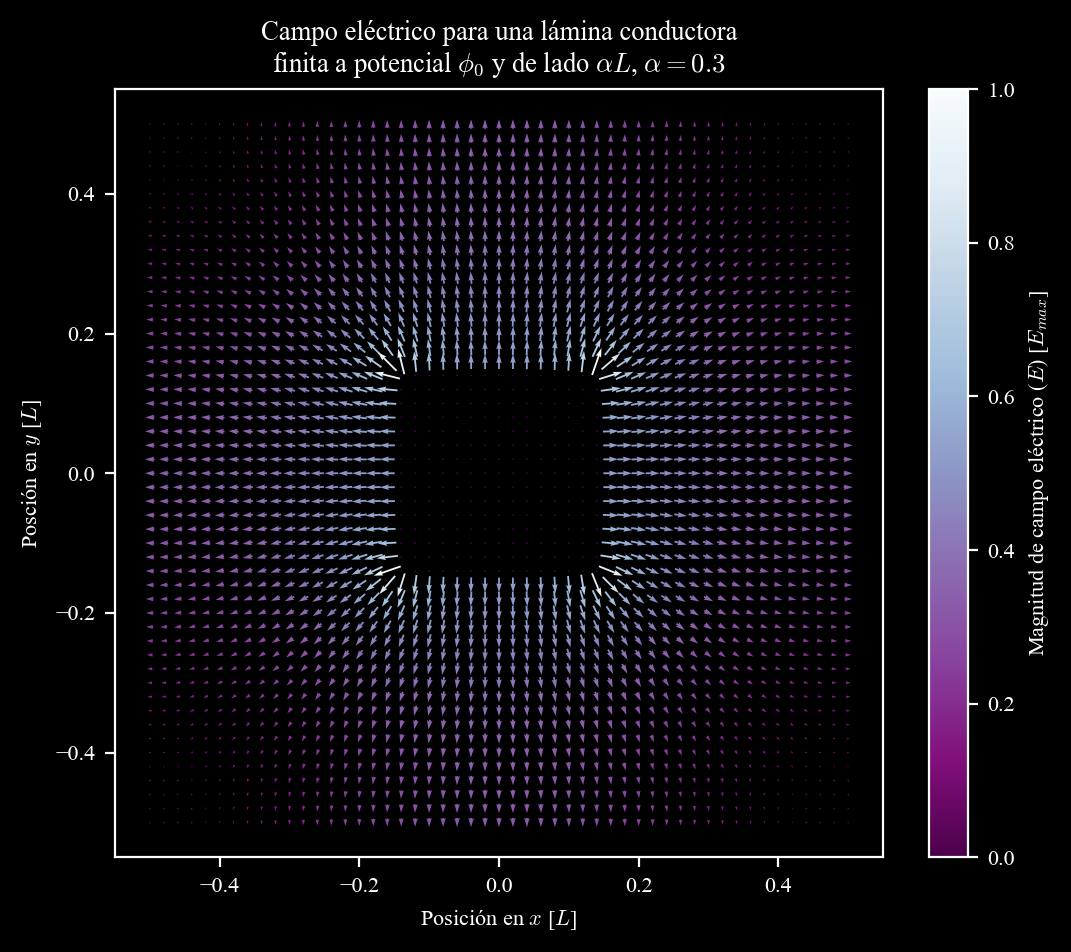

In [5]:
Ex, Ey, E = get_field(phi, step)

# Plotting
fig, ax = plt.subplots(dpi=200)
title = "Campo eléctrico para una lámina conductora\n" \
            f"finita a potencial $\phi_0$ y de lado $\\alpha L$, $\\alpha = {alpha}$"
quiver_step = 4
plot_field(Ex, Ey, E, fig, ax, title, quiver_step, equal_lengths=False)
plt.tight_layout()
plt.savefig("Figures/sheet_field.png", bbox_inches='tight')

## Example 2: Circular potential distribution

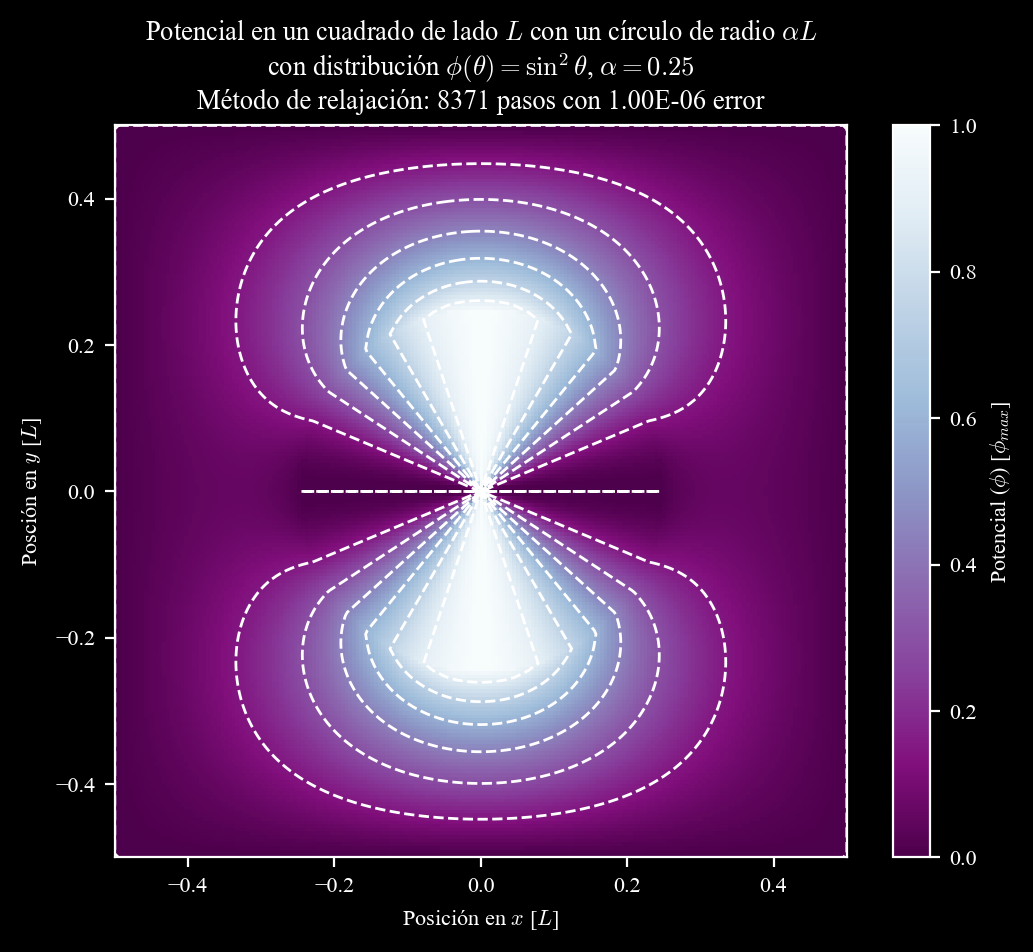

In [6]:
# Geometric parameters
rmax = 0.25
rectangle_length = 1
alpha = rmax / rectangle_length
step = 0.005

# Position, mask and potential grids
# Y, X used to plot the electric field
# Y starts on rectangle_length/2 and decreases to -rectangle_length/2 so as to have
# the maximum values at the top of the array.
Y, X = np.mgrid[rectangle_length/2:-rectangle_length/2-step:-step,
                -rectangle_length/2:rectangle_length/2+step:step]
mask = circular_mask(Y, X, rmax)

filter = (X==0) & (Y==0)
phi0 = np.zeros(Y.shape)
phi0[~filter] = Y[~filter]**2 / (X[~filter]**2 + Y[~filter]**2)
phi0[filter] = np.max(phi0)
phi = np.zeros(Y.shape) + phi0*mask
phi, n, error = relax_cartesian(phi, mask)

# Plotting
fig, ax = plt.subplots(dpi=200)
title = "Potencial en un cuadrado de lado $L$ con un círculo de radio $\\alpha L$\n" \
        f"con distribución $\\phi(\\theta) = \sin^2\\theta$, $\\alpha = {alpha}$\n" \
        f"Método de relajación: {n} pasos con {error:.2E} error"
extent = (-rectangle_length/2, rectangle_length/2, -rectangle_length/2, rectangle_length/2)

plot_potential(phi, fig, ax, title, extent)
plt.tight_layout()
plt.savefig("Figures/circle_potential.png", bbox_inches='tight')

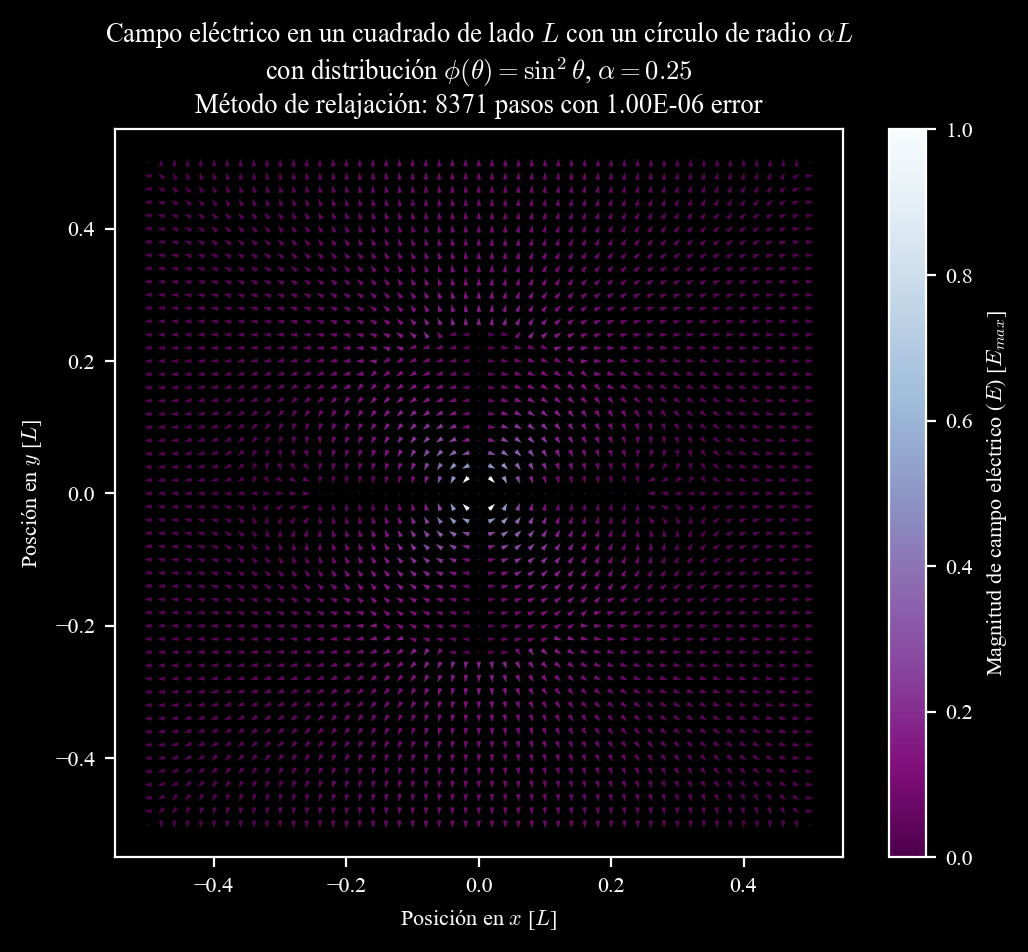

In [7]:
Ex, Ey, E = get_field(phi, step)

# Plotting
fig, ax = plt.subplots(dpi=200)
title = "Campo eléctrico en un cuadrado de lado $L$ con un círculo de radio $\\alpha L$\n" \
        f"con distribución $\\phi(\\theta) = \sin^2\\theta$, $\\alpha = {alpha}$\n" \
        f"Método de relajación: {n} pasos con {error:.2E} error"
quiver_step = 4
plot_field(Ex, Ey, E, fig, ax, title, quiver_step)
plt.tight_layout()
plt.savefig("Figures/circle_field.png", bbox_inches='tight')